# **Apple Stock Prices**

In [114]:
!pip install -q kaggle

In [115]:
from google.colab import files
#Upload Kaggle API Key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bkdr23","key":"504c387f809c2f78a8411144e5d099bd"}'}

In [116]:
!mkdir ~/.kaggle #make new directory in root folder
!cp kaggle.json ~/.kaggle/ #copy and paste kaggle API key to new directory
!chmod 600 ~/.kaggle/kaggle.json #permission
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                    title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                        DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           2844        242  1.0              
thedevastator/global-video-game-sales-and-reviews      Global Video Game Sales and Reviews          56KB  2023-12-20 06:36:51            977         27  1.0              
bhavikjikadara/car-price-prediction-dataset            Car Price Prediction Dataset                  4KB  2023-12-23 07:07:54           1046         31  0.9411765        
muhammadbinimran/housing-price-prediction-data         Housing Price Prediction Data 

In [117]:
!kaggle datasets download -d meetnagadia/apple-stock-price-from-19802021

  0% 0.00/206k [00:00<?, ?B/s]
100% 206k/206k [00:00<00:00, 94.8MB/s]


In [118]:
import numpy as np
import zipfile
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [119]:
zipPath = '../content/apple-stock-price-from-19802021.zip' #zip path in local
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/AppleStock') #extract to new directory
zipFile.close() #close connection to object

In [136]:
data = pd.read_csv('/content/AppleStock/AAPL.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900


In [137]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [138]:
data = data[['Date', 'Close']]

In [139]:
data.head()

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10468 non-null  object 
 1   Close   10468 non-null  float64
dtypes: float64(1), object(1)
memory usage: 163.7+ KB


In [145]:
mae_rate = (data['Close'].max() - data['Close'].min()) * 10/100
print(mae_rate)

18.196088800000002


In [146]:
features = data.drop('Close', axis=1)  # Adjust this based on your feature columns
target = data['Close']

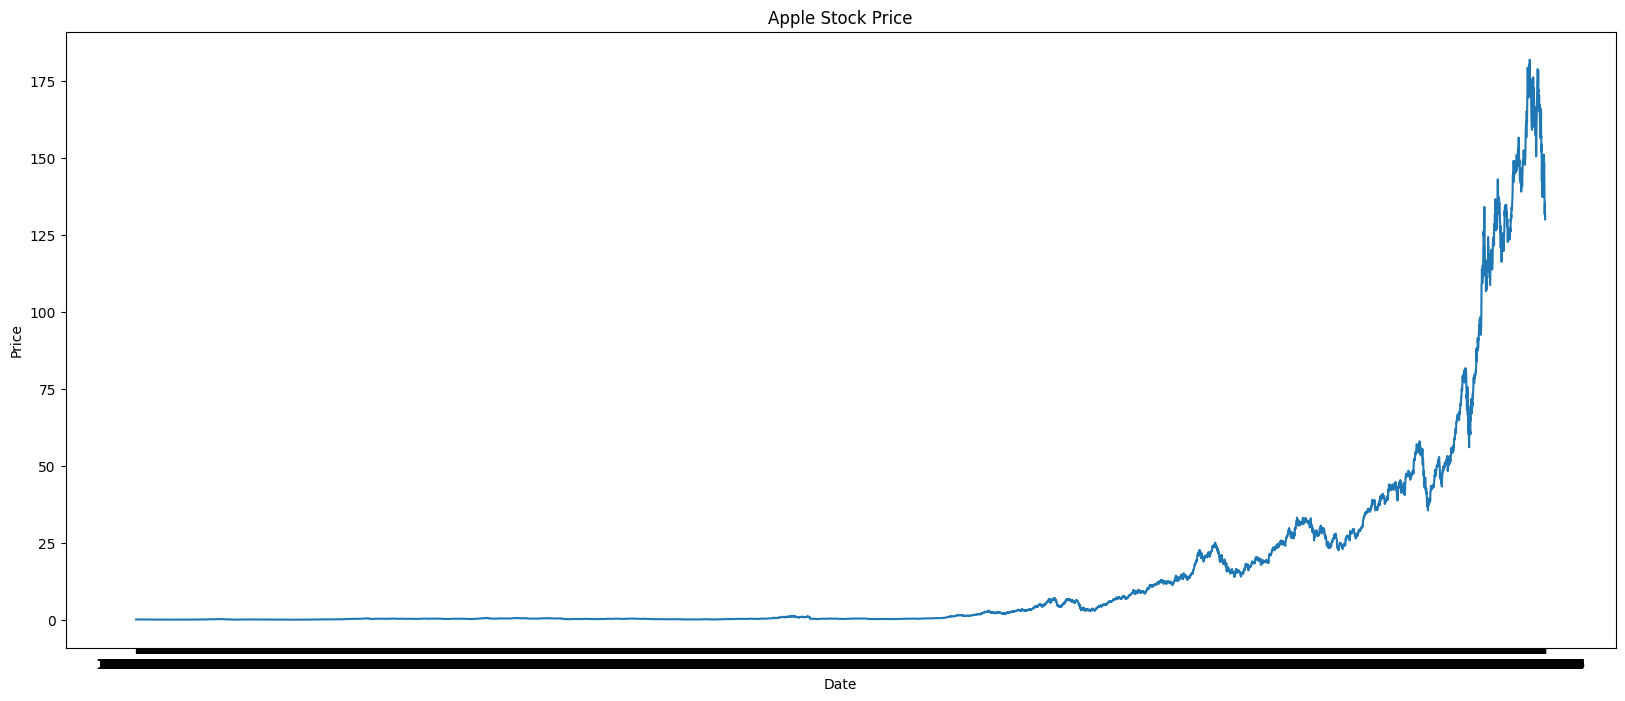

In [147]:
Date = data['Date'].values
Price = data['Close'].values

plt.figure(figsize=(20,8))
plt.plot(Date, Price)
plt.title('Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [148]:
x_train, x_test, y_train, y_test = train_test_split(Price, Date, test_size = 0.2)

In [150]:
print('Jumlah Data Train : ',len(x_train))
print('Jumah Data Test : ',len(x_test))

Jumlah Data Train :  8374
Jumah Data Test :  2094


In [151]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  data_series = tf.data.Dataset.from_tensor_slices(series)
  data_series = data_series.window(window_size + 1, shift=1, drop_remainder = True)
  data_series = data_series.flat_map(lambda w: w.batch(window_size + 1))
  data_series = data_series.shuffle(shuffle_buffer)
  data_series = data_series.map(lambda w: (w[:-1], w[-1:]))
  return data_series.batch(batch_size).prefetch(1)

In [152]:
data_training = windowed_dataset(x_train, window_size=64, batch_size=128, shuffle_buffer=1000)
data_testing = windowed_dataset(x_test, window_size=64, batch_size=128, shuffle_buffer=1000)

In [153]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

In [154]:
optimizers = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=["mae"])
model_history = model.fit(
    data_training,
    epochs=50,
    validation_data=data_testing,
)

Epoch 1/50
65/65 [==============================] - 22s 263ms/step - loss: 14.3788 - mae: 14.7189 - val_loss: 14.0091 - val_mae: 14.2896
Epoch 2/50
65/65 [==============================] - 17s 252ms/step - loss: 14.3049 - mae: 14.6522 - val_loss: 13.9547 - val_mae: 14.2630
Epoch 3/50
65/65 [==============================] - 17s 265ms/step - loss: 14.2742 - mae: 14.6348 - val_loss: 13.9276 - val_mae: 14.2654
Epoch 4/50
65/65 [==============================] - 18s 267ms/step - loss: 14.2612 - mae: 14.6255 - val_loss: 13.9110 - val_mae: 14.2705
Epoch 5/50
65/65 [==============================] - 17s 258ms/step - loss: 14.2435 - mae: 14.6159 - val_loss: 13.9002 - val_mae: 14.2755
Epoch 6/50
65/65 [==============================] - 17s 251ms/step - loss: 14.2426 - mae: 14.6204 - val_loss: 13.8961 - val_mae: 14.2778
Epoch 7/50
65/65 [==============================] - 17s 263ms/step - loss: 14.2357 - mae: 14.6113 - val_loss: 13.8920 - val_mae: 14.2804
Epoch 8/50
65/65 [=======================